# Creating a Control Network

In [1]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
# Enable the GPU
autocnet.cuda(enable=True)

from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs
# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

Populating the interactive namespace from numpy and matplotlib


## Create the CandidateGraph
Just like the other notebooks this cell creates the candidate graph.  This also patches in functionality to the object on the fly.  To get a handle on what is going on, checkout the [Advanced 1. Extending the CandidateGraph](Advanced 1. Extending the CandidateGraph.ipynb) notebook.

In [2]:
# Create the candidate graph and enable a GPU
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Define a function to do the feature extraction.
def extract_features(self, arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    # Match the interface defined in the edge.
    self.keypoints = kp
    self.descriptors = des
    
    self['downsample_amount'] = downsample_amount

# Import the class and update it.  This updates the current instance of the CandidateGraph
from autocnet.graph.node import Node
Node.extract_features = extract_features

# Extract the features
cg.extract_features(thresh=1)

# Match
cg.match()

# Apply outlier detection - see the above linked notebook if you are curious about what is going on here.
for s,d,e in cg.edges_iter(data=True):
    e.masks['ratio'] = e.matches.ambiguity <= e.matches.ambiguity.quantile(0.015)
    e.masks['score'] = e.matches.score >= e.matches.score.quantile(0.85)
    
# Compute the F Matrix
cg.compute_fundamental_matrices(clean_keys=['ratio', 'score'])

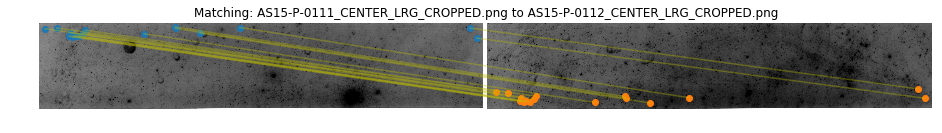

In [3]:
cg.edge[0][1].plot(clean_keys=['fundamental'], line_kwargs={'alpha':0.35}, downsampling=True)

In [6]:
# Apply the subpixel matcher
import cv2
# Scale the keypoints coordinates back to full resolution.
for i, n in cg.nodes_iter(data=True):
    n.keypoints.x *= n['downsample_amount']
    n.keypoints.y *= n['downsample_amount']
    
cg.subpixel_register(clean_keys=['fundamental'], tiled=True, func=cv2.TM_CCORR_NORMED, max_x_shift=7, max_y_shift=7)

# Scale the keypoint coordinates back to the reduced resolution
for i, n in cg.nodes_iter(data=True):
    n.keypoints.x /= n['downsample_amount']
    n.keypoints.y /= n['downsample_amount']

In [7]:
# Create a control network object
cg.generate_cnet(clean_keys=['subpixel'])

In [18]:
# Write the (invalid) control network to disk - this net is not valid because it does not have isis3 serial numbers...use cubes
from plio.io.io_controlnetwork import to_isis
to_isis('sample_pan.net', cg.cn, mode='wb', targetname='Moon')

In [23]:
!ls -alh *.net

-rw-r--r-- 1 jlaura flagstaf 294K May 17 13:20 sample_pan.net
